In [1]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, LeakyReLU, Reshape, Conv2D, Conv2DTranspose, Dropout, Flatten

In [2]:
import matplotlib.pyplot as plt

In [3]:
value = tf.random.normal([1, 100])

In [4]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()

In [5]:
print(train_images.shape)
print(train_images.dtype)

train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')

print(train_images.shape)
print(train_images.dtype)

(60000, 28, 28)
uint8
(60000, 28, 28, 1)
float32


In [6]:
train_images = (train_images - 127.5)/127.5  # Normalize images to [-1, 1]

In [7]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

In [8]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

## Create Model

In [9]:
def create_generator_model():
    model = Sequential()
    
    model.add(Dense(7*7*256, use_bias=False, input_shape=(100, )))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    
    model.add(Reshape((7, 7, 256))) # current image size= 7 x 7 x 256
    
    model.add(Conv2DTranspose(128, (5,5), strides=(1,1), padding='same', use_bias=False))  # current image size= 7 x 7 x 128
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    
    model.add(Conv2DTranspose(64, (5,5), strides=(2,2), padding='same', use_bias=False))  # current image size= 14 x 14 x 64
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    
    model.add(Conv2DTranspose(1, (5,5), strides=(2,2), padding='same', use_bias=False, activation='tanh'))  # current image size= 28 x 28 x 1
    
    return model
    

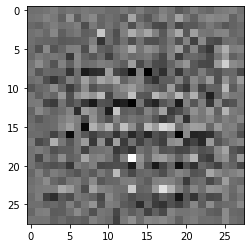

In [10]:
generator = create_generator_model()

noise = tf.random.normal([1, 100])

generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

## Define Discriminator

The discriminator is a CNN-Based image classifier

In [11]:
def create_discriminator_model():
    model = Sequential()
    
    model.add(Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]))
    model.add(LeakyReLU())
    model.add(Dropout(0.3))
    
    model.add(Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(LeakyReLU())
    model.add(Dropout(0.3))
    
    model.add(Flatten())
    model.add(Dense(1))
    
    return model

In [12]:
discriminator = create_discriminator_model()

discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 14, 64)        1664      
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 7, 7, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 6272)             

In [13]:
decision = discriminator(generated_image)
print(decision)

tf.Tensor([[0.00032171]], shape=(1, 1), dtype=float32)


 ## Loss function

In [14]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

### Discriminator Loss

This method quantifies how well the discriminator is able to distinguish real images from fakes. It compares the discriminator's predictions on real images to an array of 1s, and the discriminator's predictions on fake(generated) images to an array of 0s.

In [15]:
def discriminator_loss(real_output, fake_output):
    
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    
    total_loss = real_loss + fake_loss
    
    return total_loss

### Generator Loss

The generator's loss quantifies how well it was able to trick the discriminator. Intuitively, if the generator is performing well, the discriminator will classify the fake images as real (or 1). Here, we will compare the discriminator decisions on the generated images to an array of 1s

In [16]:
def generator_loss(fake_output):
    
    return cross_entropy(tf.ones_like(fake_output), fake_output)

### Optimizers for discriminator and generator

In [17]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)

discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)